In [1]:
!pip install fasttext
!pip install gensim
!pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 36.5 MB/s eta 0:00:0000:0100:01


In [2]:
import json
import re
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import seaborn as sns
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import CountVectorizer
import gensim.models
import pymorphy2

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

import fasttext
import fasttext.util

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# ФУНКЦИИ ЭМБЕДДИНГОВ

# функция, возвращает векторизированное предложение
def get_vector(model, sentence, vector_size=100):
    sentence_vector = []

    if len(sentence) == 0:
        # Пустые предложения заполним их одним  словом
        token_vector = np.zeros(vector_size)
        sentence_vector.append(token_vector)
    else:
        for token in sentence:
            try:
                token_vector = model.wv[token]
            except KeyError as e:
                print('here')
                # Случай неизвестного слова
                token_vector = np.zeros(vector_size)
            finally:
                sentence_vector.append(token_vector)
    
    return np.mean(sentence_vector, axis=0)

# функция, возвращает векторизированные выборки
def vectorize_train_test(model, texts, vector_size=300):
    texts_vectorized = np.zeros((len(texts), vector_size))
    for index, sentence in enumerate(texts):
        texts_vectorized[index] = get_vector(model, sentence, vector_size)
        
    return texts_vectorized

# функция, косинусная метрика сходства векторов
def cosine_similarity(emb1, emb2):
    return np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))

In [4]:
# ФУНКЦИИ ОБРАБОТКИ ДАТАСЕТА

# функция предобработки поля "languageKnowledge"
def lang_preprocessing(text):
    obj = json.loads(text)
    lang_str = ''
    for i in range(len(obj)):
        try:
            lang_str += obj[i]['level'] + ' ' + obj[i]['code_language'] + ' язык' + ' '
        except:
            try:
                lang_str += obj[i]['code_language'] + ' язык' + ' '
            except:
                pass
    return lang_str.strip().lower()

# функция предобработки полей навыков
def skills_preprocessing(text, skill_name):
    skills_str = ''
    try:
        obj = json.loads(text)
        for i in range(len(obj)):
            skills_str += obj[i][skill_name] + ' '
        return skills_str.strip().lower()
    except:
        return skills_str.strip().lower()
    
# функция предобработки поля 'required_drive_license'
def drive_license_preprocessing(text):
    drive_license_str = ''
    try:
        obj = json.loads(text)
        if len(obj) > 0:
            drive_license_str = 'права категории '
        for i in range(len(obj)):
            drive_license_str += obj[i] + ' '
        return drive_license_str.strip().lower()
    except:
        return drive_license_str.strip().lower()
    
    
# функция, очистка от html разметки
def clean_html_bs4(text_data):
    soup = BeautifulSoup(text_data, 'lxml')
    return soup.get_text()

# функция, очистка от мусора, нормализация и лемматизация
def tokenize(text, stopwords, need_lemmatize=False):
    result = []
    sentences = [item for item in sent_tokenize(str(text))]

    for sentence in sentences:
        text = sentence.lower()
        text = clean_html_bs4(text)
        text = re.sub(r"\s+", ' ', text)

        tokens = [item for item in word_tokenize(text)]
        tokens = [re.sub("[^а-яА-Яa-zA-Z]", ' ', item) for item in tokens]

        if need_lemmatize:
            tokens = [analyzer.parse(token)[0].normal_form for token in tokens if token not in stopwords  and ' ' not in token and len(token) > 2]
            tokens = [token for token in tokens if token not in lemmatized_sw]
        tokens = [re.sub(r"ё", "е", token) for token in tokens]
        result.extend(tokens)
    return result


In [5]:
sw = stopwords.words('russian')
additional_sw =  'мои оно мной мною мог могут мор мое мочь оба нам нами ними однако нему никуда наш нею неё наша наше наши очень отсюда вон вами ваш ваша ваше ваши весь всем всеми вся ими ею будем будете будешь буду будь будут кому кого которой которого которая которые который которых кем каждое каждая каждые каждый кажется та те тому собой тобой собою тобою тою хотеть хочешь свое свои твой своей своего своих твоя твоё сама сами теми само самом самому самой самого самим самими самих саму чему тебе такое такие также такая сих тех ту эта это этому туда этим этими этих абы аж ан благо буде вроде дабы едва ежели затем зато ибо итак кабы коли коль либо лишь нежели пока покамест покуда поскольку притом причем пускай пусть ровно сиречь словно также точно хотя чисто якобы '
pronouns = 'я мы ты вы он она оно они себя мой твой ваш наш свой его ее их то это тот этот такой таков столько весь всякий сам самый каждый любой иной другой кто что какой каков чей сколько никто ничто некого нечего никакой ничей нисколько кто-то кое-кто кто-нибудь кто-либо что-то кое-что что-нибудь что-либо какой-то какой-либо какой-нибудь некто нечто некоторый некий'
conjunctions = 'что чтобы как когда ибо пока будто словно если потому что оттого что так как так что лишь только как будто с тех пор как в связи с тем что для того чтобы кто как когда который какой где куда откуда'
digits = 'ноль один два три четыре пять шесть семь восемь девять десять одиннадцать двенадцать тринадцать четырнадцать пятнадцать шестнадцать семнадцать восемнадцать девятнадцать двадцать тридцать сорок пятьдесят шестьдесят семьдесят восемьдесят девяносто сто'
modal_words = 'вероятно возможно видимо по-видимому кажется наверное безусловно верно  действительно конечно несомненно разумеется'
particles = 'да так точно ну да не ни неужели ли разве а что ли что за то-то как ну и ведь даже еще ведь уже все все-таки просто прямо вон это вот как словно будто точно как будто вроде как бы именно как раз подлинно ровно лишь только хоть всего исключительно вряд ли едва ли'
prepositions = 'близ  вблизи  вдоль  вокруг  впереди  внутрь  внутри  возле  около  поверх  сверху  сверх  позади  сзади  сквозь  среди  прежде  мимо  вслед  согласно  подобно  навстречу  против  напротив  вопреки  после  кроме  вместе  вдали  наряду  совместно  согласно  нежели вроде от бишь до без аж тех раньше совсем только итак например из прямо ли следствие а поскольку благо пускай благодаря случае затем притом также связи время при чтоб просто того невзирая даром вместо точно покуда тогда зато ради ан буде прежде насчет раз причине тому так даже исходя коль кабы более ровно либо помимо как-то будто если словно лишь бы и не будь пор тоже разве чуть как хотя наряду потому пусть в равно между сверх ибо на судя то чтобы относительно или счет за но сравнению причем оттого есть когда уж ввиду тем для дабы чем хоть с вплоть скоро едва после той да вопреки ежели кроме сиречь же коли под абы несмотря все пока покамест паче прямо-таки перед что по вдруг якобы подобно'
evaluative = 'наиболее наименее лучший больший высший низший худший более менее'

sw.extend(additional_sw.split())
sw.extend(pronouns.split())
sw.extend(conjunctions.split())
sw.extend(digits.split())
sw.extend(modal_words.split())
sw.extend(particles.split())
sw.extend(prepositions.split())
sw.extend(evaluative.split())
sw = list(set(sw))

## Вакансии

#### Чтение данных

In [6]:
df_vacs = pd.read_csv('/kaggle/input/vacancy/vacancy.csv', sep='|')

/tmp/ipykernel_42/3097909870.py:1: DtypeWarning: Columns (1,69) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vacs = pd.read_csv('/kaggle/input/vacancy/vacancy.csv', sep='|')


In [7]:
columns = ['additional_requirements', 'busy_type', 'languageKnowledge', 'education', 'education_speciality',
           'hardSkills', 'softSkills','position_requirements', 'position_responsibilities',
           'regionName', 'required_drive_license', 'salary', 'salary_min', 'salary_max', 'schedule_type',
           'vacancy_name', 'professionalSphereName']

In [8]:
df_vacs = df_vacs[columns]
df_vacs = df_vacs.fillna('')

#### Предобработка полей

In [9]:
df_vacs['languageKnowledge'] = df_vacs['languageKnowledge'].apply(lambda text: lang_preprocessing(text))
df_vacs['hardSkills'] = df_vacs['hardSkills'].apply(lambda text: skills_preprocessing(text, skill_name='hard_skill_name'))
df_vacs['softSkills'] = df_vacs['softSkills'].apply(lambda text: skills_preprocessing(text, skill_name='soft_skill_name'))
df_vacs['required_drive_license'] = df_vacs['required_drive_license'].apply(lambda text: drive_license_preprocessing(text))

In [10]:
df_vacs = df_vacs.head(1000)
df_vacs

,additional_requirements,busy_type,languageKnowledge,education,education_speciality,hardSkills,softSkills,position_requirements,position_responsibilities,regionName,required_drive_license,salary,salary_min,salary_max,schedule_type,vacancy_name,professionalSphereName
0,,Полная занятость,,Среднее,,,,"<p>Среднее полное образование, знание ПК, умен...",<p>Выполнение входного контроля трубной загото...,Свердловская область,,от 23000,23000.0,35000.0,Полный рабочий день,техник-лаборант,Производство
1,,Полная занятость,,Высшее,Юриспруденция,,,<ul> <li>Основы документооборота</li> <li>Осно...,<ul> <li>Анализ затрат на взыскание задолженно...,Ямало-Ненецкий автономный округ,,от 50000,50000.0,0.0,Полный рабочий день,Юрист,Юриспруденция
2,,Полная занятость,,Основное общее,,,,"<p>Можно без опыта, обучаемость</p>",<p>Уборка и мойка грузовых и легковых автомоби...,Свердловская область,,от 20000,20000.0,0.0,Сменный график,Мойщик автомобилей,"Транспорт, автобизнес, логистика, склад, ВЭД"
3,<p>вахта 30*30</p>,Полная занятость,,Среднее,,,,<p>Ответственность</p>,<p>Эксплуатация паровой котельной установки на...,Ямало-Ненецкий автономный округ,,от 90000,90000.0,90000.0,Вахтовый метод,Оператор котельной,Рабочие специальности
4,,Полная занятость,,Среднее,,,,<p>Обучаемость</p>,"<p>Выкладка товара, контроль сроков годности, ...",Свердловская область,,от 23000,23000.0,27000.0,Полный рабочий день,Продавец продовольственных товаров,"Продажи, закупки, снабжение, торговля"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,,Временная,,Не указано,,,,<p>Внимательность</p>,<p>Согласно должностной инструкции</p>,Свердловская область,,от 22195,22195.0,22195.0,Полный рабочий день,Кухонный рабочий,Пищевая промышленность
996,,Полная занятость,,Не указано,,,,,<br/><p>Крупной федеральной компании на объект...,Челябинская область,,от 55000,55000.0,55000.0,Вахтовый метод,Бетонщик-арматурщик,Рабочие специальности
997,,Полная занятость,,Не указано,,,,,<br/><p>Крупной федеральной компании на объект...,Челябинская область,,от 55000,55000.0,55000.0,Вахтовый метод,Бетонщик-арматурщик,Рабочие специальности
998,,Полная занятость,,Не указано,,,,,<br/><p>Крупной федеральной компании на объект...,Челябинская область,,от 55000,55000.0,55000.0,Вахтовый метод,Бетонщик-арматурщик,Рабочие специальности


#### Очистка и токенизация

In [11]:
analyzer = pymorphy2.MorphAnalyzer()
lemmatized_sw = [analyzer.parse(word)[0].normal_form for word in sw]

vacs_docs = []
for index, row in df_vacs.iterrows():
    line = ' '.join([str(item) for item in row.values]).lower()
    vacs_docs.append(tokenize(line, stopwords=sw, need_lemmatize=True))

/tmp/ipykernel_42/3936847084.py:44: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text_data, 'lxml')


#### Векторизация

In [12]:
fasttext = gensim.models.fasttext.load_facebook_model('/kaggle/input/fasttext/cc.ru.300.bin')

In [13]:
# fasttext = gensim.models.FastText(vector_size=300, window=7, min_count=3)
# fasttext.build_vocab(corpus_iterable=vacs_docs)

# fasttext.train(
#     corpus_iterable=vacs_docs,
#     total_examples=len(vacs_docs),
#     epochs=20
#     )

In [14]:
vacs_vecs = vectorize_train_test(fasttext, vacs_docs, vector_size=300)
vacs_vecs = pd.DataFrame(vacs_vecs).add_prefix('vacs_')

#### Кластеризация

In [15]:
ks = range(1, 150)
sse = []
for k in ks:
    model = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=48)
    model.fit(vacs_vecs)
    sse.append(model.inertia_)

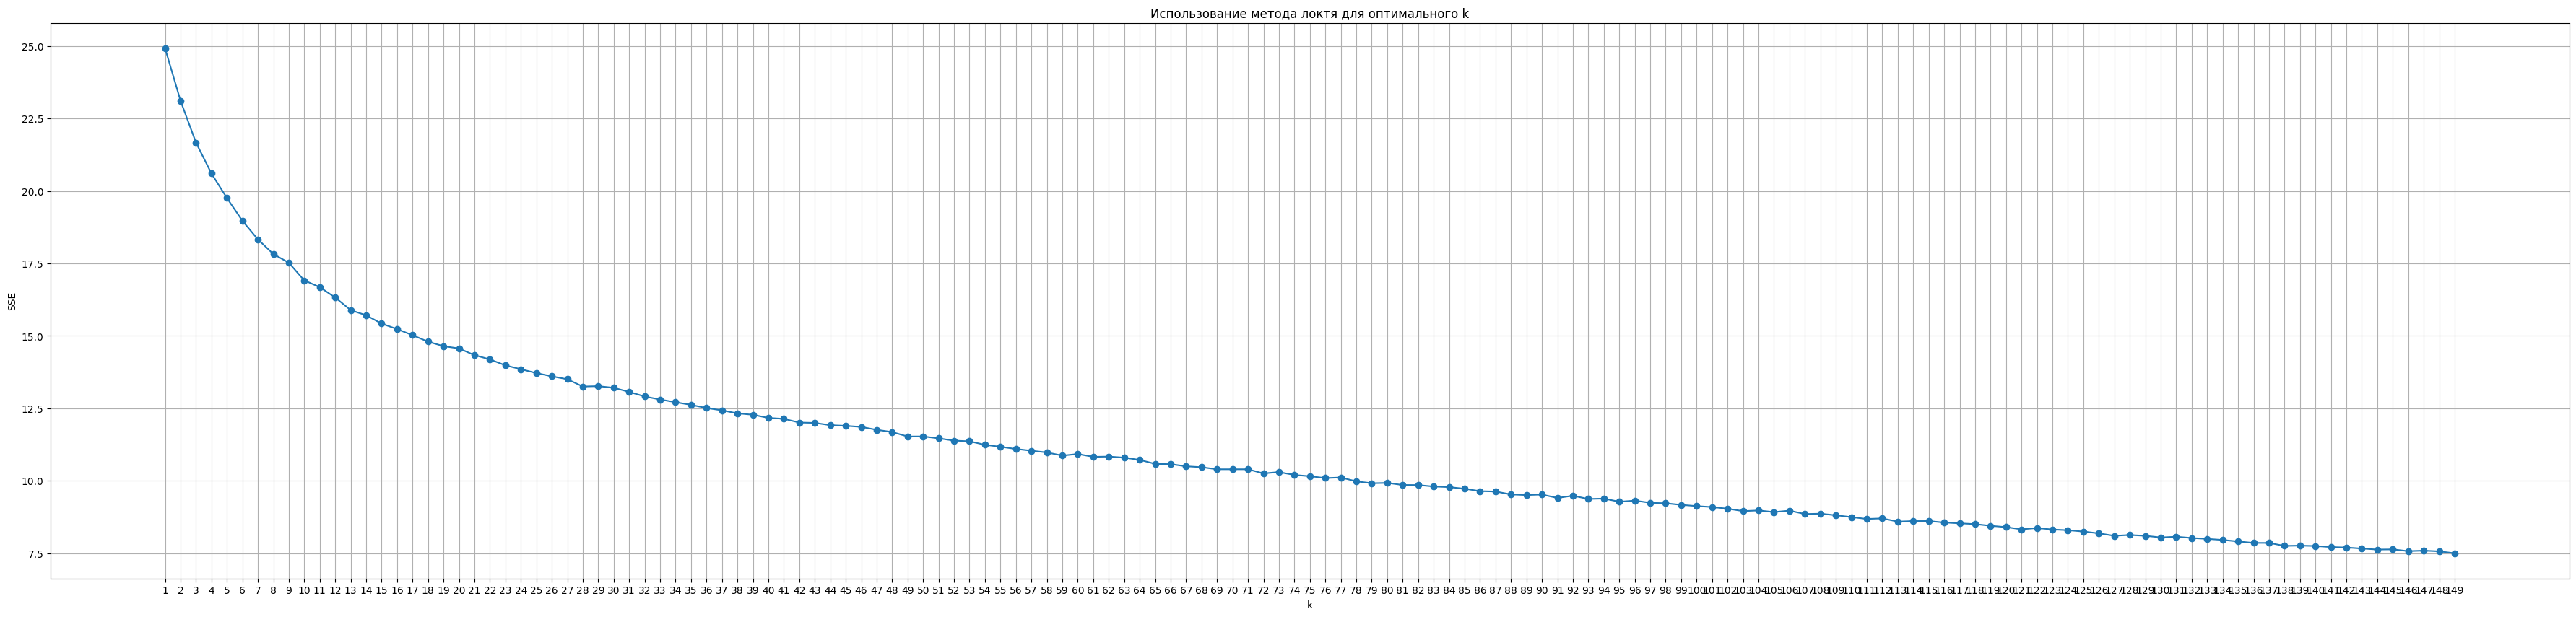

In [16]:
plt.subplots(figsize=(45, 10))
plt.plot(ks, sse, '-o')
plt.xlabel('k')
plt.ylabel('SSE')
plt.xticks(ks)
plt.title('Использование метода локтя для оптимального k')
# plt.axvline(x=3, )
plt.grid()
plt.savefig('k_sse.jpg')
plt.show()

In [17]:
ks = range(2, 150)
db_scores = []
for k in ks:
    model = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=48)
    clust_labels = model.fit_predict(vacs_vecs)
    db_score = davies_bouldin_score(vacs_vecs, clust_labels)
    db_scores.append(db_score)

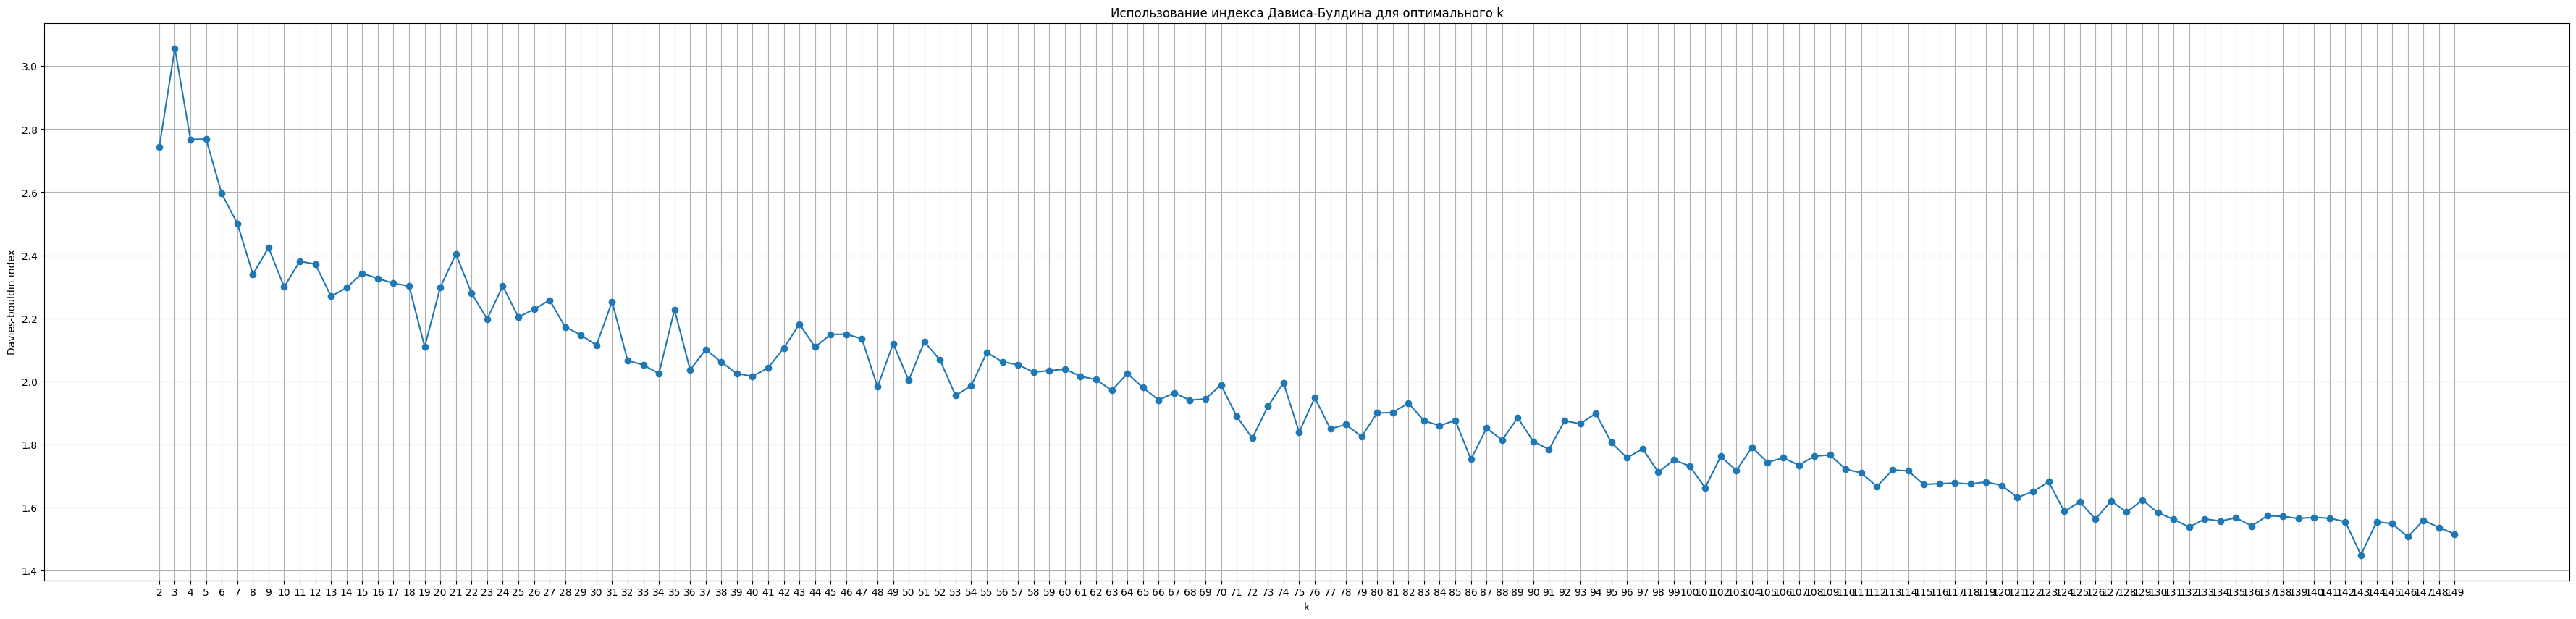

In [18]:
plt.subplots(figsize=(45, 10))
plt.plot(ks, db_scores, '-o')
plt.xlabel('k')
plt.ylabel('Davies-bouldin index')
plt.xticks(ks)
plt.title('Использование индекса Дависа-Булдина для оптимального k')
# plt.axvline(x=3, )
plt.grid()
plt.savefig('k_db_index.jpg')
plt.show()

In [43]:
best_k = 40
print('SSE:', sse[best_k - 1])
print('Davies-Bouldin index:', db_scores[best_k - 2])

SSE: 12.170080675891018
Davies-Bouldin index: 2.015866886977208


In [20]:
model = KMeans(n_clusters=best_k, init='k-means++', n_init=10, random_state=48)
clust_labels = model.fit_predict(vacs_vecs)

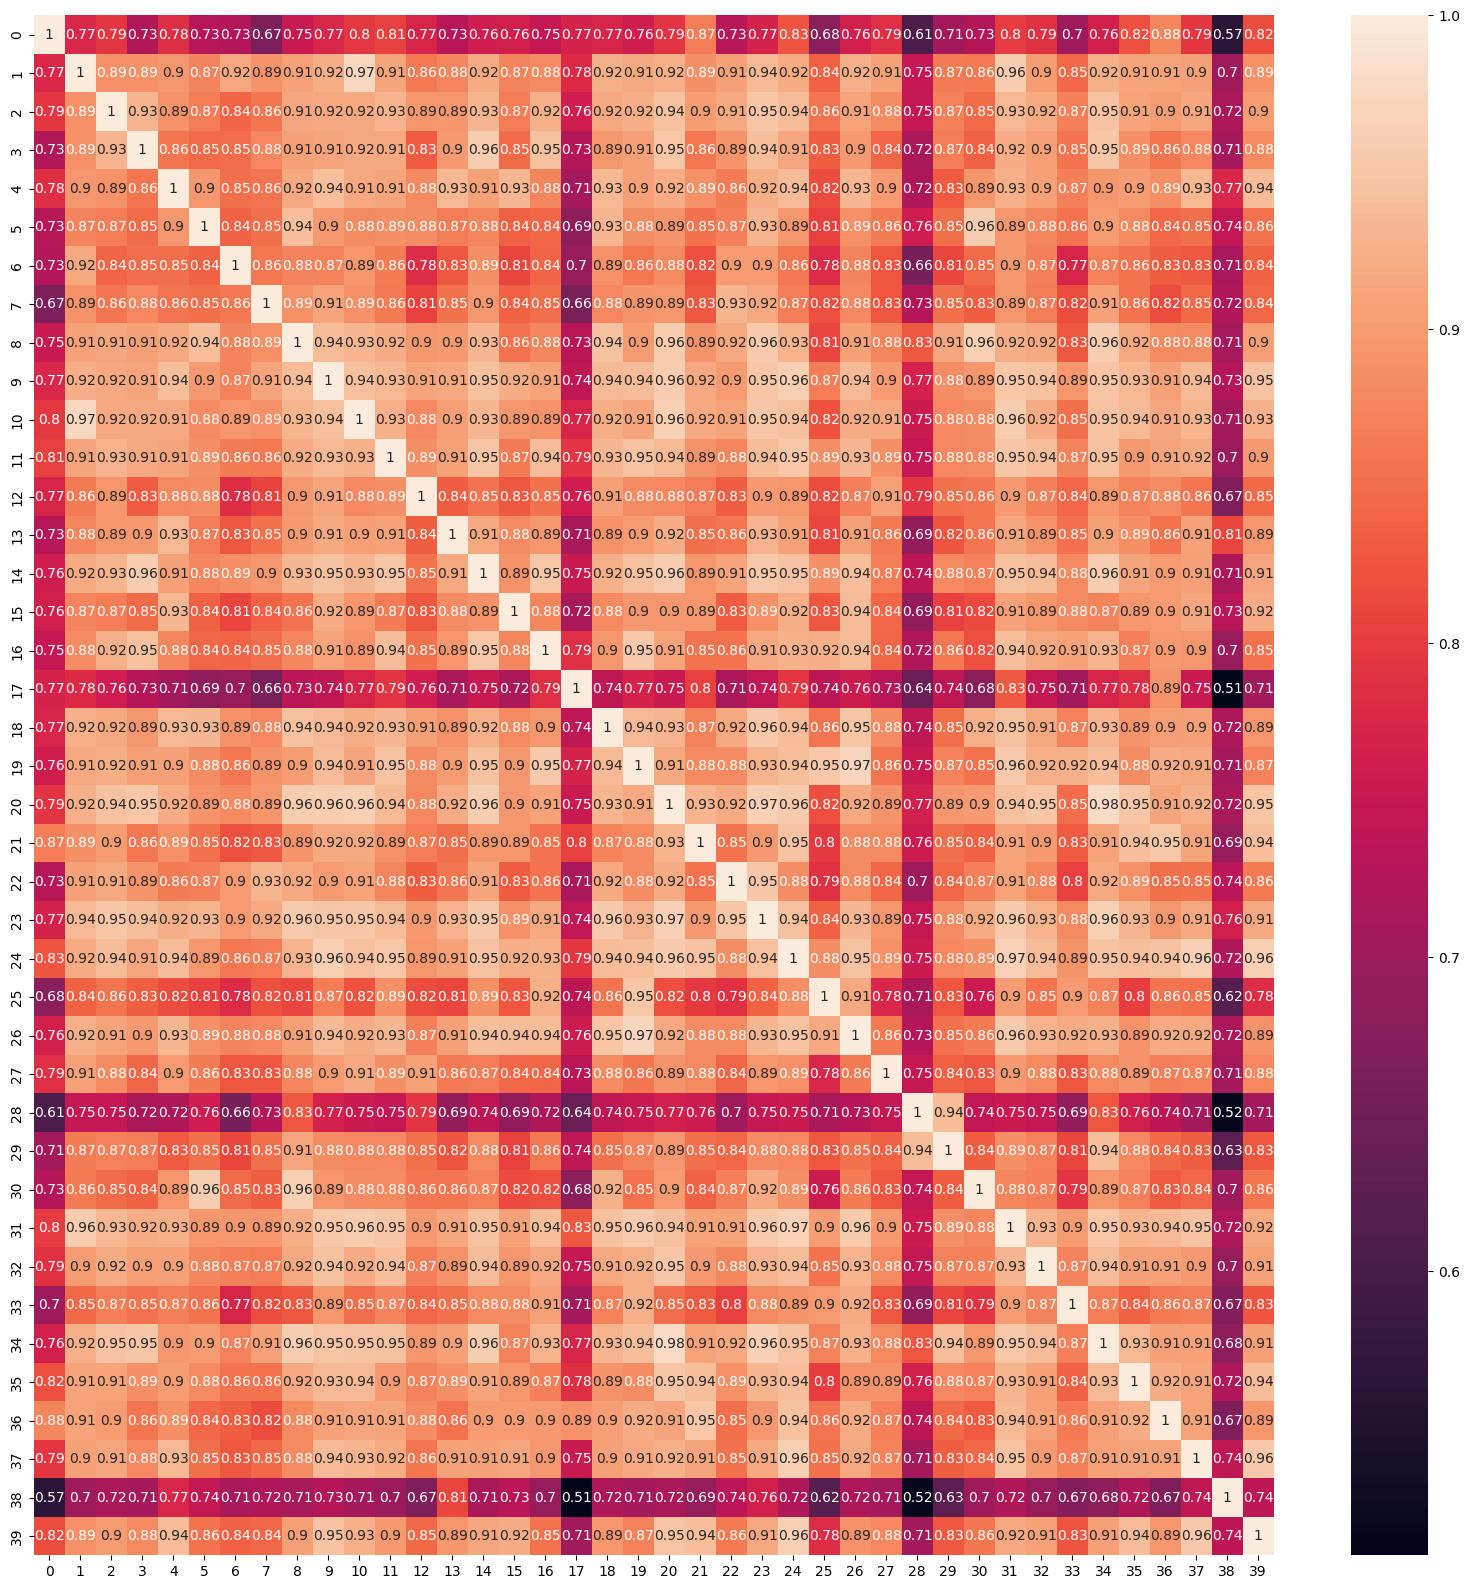

In [44]:
centers_count = len(model.cluster_centers_)

matrix = np.zeros((centers_count, centers_count))

for i in range(centers_count):
    for j in range(centers_count):
        matrix[i][j] = cosine_similarity(model.cluster_centers_[i], model.cluster_centers_[j])
        
plt.subplots(figsize=(20, 20))
sns.heatmap(matrix, annot=True)
plt.savefig('centroids_heatmap.jpg')
plt.show()

In [22]:
df_vacs.iloc[np.where(clust_labels == 29)]['vacancy_name']

102                    бухгалтер расчетного отдела
187                                      Бухгалтер
342                              Главный бухгалтер
482    экономист по договорно-претензионной работе
488                              Главный бухгалтер
531                          бухгалтер 1 категории
563                                      Бухгалтер
705                              Ведущий экономист
810                              Ведущий бухгалтер
845                                      Бухгалтер
893                                      Бухгалтер
923                          экономист 1 категории
Name: vacancy_name, dtype: object

In [23]:
df_vacs.iloc[np.where(clust_labels == 0)]['vacancy_name']

512    Оператор котельной 3 разряда
Name: vacancy_name, dtype: object

In [24]:
df_vacs.iloc[np.where(clust_labels == 1)]['vacancy_name']

428    Бетонщик-арматурщик
429    Бетонщик-арматурщик
430    Бетонщик-арматурщик
431    Бетонщик-арматурщик
432    Бетонщик-арматурщик
              ...         
994    Бетонщик-арматурщик
996    Бетонщик-арматурщик
997    Бетонщик-арматурщик
998    Бетонщик-арматурщик
999    Бетонщик-арматурщик
Name: vacancy_name, Length: 110, dtype: object

In [25]:
df_vacs.iloc[np.where(clust_labels == 2)]['vacancy_name']

12           Инженер по охране окружающей среды (эколог)
116    Специалист по дизайну графических и пользовате...
123                                  Инженер-программист
136                  Техник службы технической поддержки
168                                  Инженер-программист
216                              Системный администратор
337                                   Техник программист
407                                             Технолог
593    Старший помощник начальника отделения по (АСУ)...
642          специалист отдела информационных технологий
832                                     Java Разработчик
835                          Старший мастер службы линий
897                                          Программист
Name: vacancy_name, dtype: object

In [26]:
df_vacs.iloc[np.where(clust_labels == 3)]['vacancy_name']

6                                            Воспитатель
22       Педагог-психолог (психолог в сфере образования)
91                                              Методист
115             Ведущий специалист по общему образованию
158    Преподаватель (в колледжах, университетах и др...
184                    Мастер производственного обучения
197                  Педагог дополнительного образования
209                  педагог дополнительного образования
214         Заместитель директора по методической работе
238                                              логопед
262                                             Режиссер
299                                   Учитель технологии
341    Преподаватель (в колледжах, университетах и др...
366                     Учитель истории и обществознания
400                  Учитель (преподаватель) информатики
439                                        преподаватель
473                    мастер производственного обучения
476                            

In [27]:
df_vacs.iloc[np.where(clust_labels == 27)]['vacancy_name']

3                                     Оператор котельной
53     Инженер по контрольно-измерительным приборам и...
453                                            Диспетчер
455                                            Диспетчер
456                                            Диспетчер
457                                            Диспетчер
458                                            Диспетчер
459                                            Диспетчер
460                                            Диспетчер
461                                            Диспетчер
462                                            Диспетчер
463                                            Диспетчер
487                                    слесарь-сантехник
571                                       водитель трала
657                                   водитель вездехода
Name: vacancy_name, dtype: object

In [28]:
df_vacs.iloc[np.where(clust_labels == 19)]['vacancy_name']

7                                  Подсобный рабочий
9                                  Подсобный рабочий
10                   Рабочий плодоовощного хранилища
21                              санитар ветеринарный
24                                          Менеджер
30                                    Мойщица посуды
32                                   помощник повара
48                                     врач-невролог
54                          Врач-терапевт участковый
75                                             Повар
89                          врач приемного отделения
145                                            Повар
151                                    Администратор
154                                    Врач-психиатр
160                             Машинист экскаватора
174                                         Кондитер
188                                            Повар
192                                    врач-невролог
195                                Кухонный ра

In [29]:
df_vacs.iloc[np.where(clust_labels == 16)]['vacancy_name']

5                                     Медицинская сестра
29                                    Социальный педагог
43                                   педагог-организатор
74                                         преподаватель
144       Ведущий ветеринарный врач ветеринарной станции
150                  Педагог дополнительного образования
171                     учитель истории и обществознания
228                                          воспитатель
230                                  Младший воспитатель
239                  руководитель физического воспитания
261                                   учитель математики
268    ведущий ветеринарный врач Ленинского ветеринар...
317                             Музыкальный руководитель
331                                  Младший воспитатель
333                                          воспитатель
395                             Музыкальный руководитель
509                                  младший воспитатель
521                            

In [30]:
df_vacs.iloc[np.where(clust_labels == 13)]['vacancy_name']

37                                       повар
39                Мастер пищевого производства
92                           пекарь - кондитер
125                                      Повар
133                                      повар
223                                      Повар
302                                      Повар
339                                   официант
369                             Разрубщик мяса
477                                      Повар
528                                      повар
535                            Помощник повара
567        Изготовитель пищевых полуфабрикатов
569                            повар универсал
583                                     пекарь
602                                      Повар
612                                      Повар
636                           Кухонный рабочий
654    Артист Муниципального духового оркестра
664                            пекарь-кондитер
688                                      Повар
761          

In [31]:
print('Электрогазосварщик')
results = []
vac_test = vacs_vecs.iloc[828]

for index, row in df_vacs.tail(30).iterrows():
    results.append([row['vacancy_name'], cosine_similarity(vac_test, vacs_vecs.iloc[index])])

results = pd.DataFrame(results, columns=['Position', 'Distance'])
results

Электрогазосварщик


,Position,Distance
0,Контролер газового хозяйства,0.821564
1,Охранник подразделения охраны,0.743235
2,Монтажник,0.831199
3,Слесарь по эксплуатации и ремонту газового обо...,0.843875
4,намазчик деталей,0.870330
5,Кладовщик (75485),0.764736
6,Контролер газового хозяйства,0.812201
7,Тракторист трелевочного трактора ТТ 4,0.729115
8,Маркировщик (оператор этикетировочного станка),0.806521
9,Электромонтер по ремонту и обслуживанию электр...,0.829971


## Резюме

In [32]:
columns = ['title', 'city', 'area', 'desired_wage', 'education_level', 'languages', 'skills', 'about']
df_cvs = pd.read_csv('/kaggle/input/resumes/resumes.csv')[columns]

In [33]:
analyzer = pymorphy2.MorphAnalyzer()
lemmatized_sw = [analyzer.parse(word)[0].normal_form for word in sw]

cvs_docs = []
for index, row in df_cvs.iterrows():
    line = ' '.join([str(item) for item in row.values]).lower()
    cvs_docs.append(tokenize(line, stopwords=sw, need_lemmatize=True))

/tmp/ipykernel_42/3936847084.py:44: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text_data, 'lxml')
/tmp/ipykernel_42/3936847084.py:44: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(text_data, 'lxml')


In [34]:
df_cvs.values[0]

array(['Водитель-курьер Подработка', 'Барнаул', "['Курьер', 'Водитель']",
       50000, 'Высшее образование',
       "{'Русский': 'Родной', 'Английский': 'A1', 'Немецкий': 'A1'}",
       "['Обучаемость', 'Русский — Родной', 'Английский — A1 — Начальный', 'Немецкий — A1 — Начальный']",
       'Активный,Ответственный, целеустремлённый, надёжный человек! С хорошей быстрой обучаймостью! Справляюсь с большим обьёмом информации!!! С Высокой Работаспособнастью!!! Имею опыт в продажах! НЕ ИМЕЮ ВРЕДНЫХ ПРИВЫЧЕК!!! Есть Сан.книжка!'],
      dtype=object)

In [35]:
cvs_vecs = vectorize_train_test(fasttext, cvs_docs, vector_size=300)
cvs_vecs = pd.DataFrame(cvs_vecs).add_prefix('cvs_')

In [36]:
cv_index = 10
df_cvs.iloc[cv_index]

title                                                Инженер-механик
city                                                     Усть-Илимск
area               ['Сервисный инженер, инженер-механик', 'Механик']
desired_wage                                                       0
education_level                                   Высшее образование
languages                  {'Русский': 'Родной', 'Английский': 'A1'}
skills             ['Техническая эксплуатация', 'Руководство колл...
about              Творческий, но не отрывающийся от земли лидер....
Name: 10, dtype: object

In [37]:
temp = cvs_vecs.iloc[cv_index]
temp

cvs_0      0.025538
cvs_1     -0.002779
cvs_2      0.005604
cvs_3      0.008879
cvs_4     -0.021043
             ...   
cvs_295   -0.012688
cvs_296    0.022056
cvs_297   -0.003002
cvs_298   -0.016682
cvs_299   -0.002501
Name: 10, Length: 300, dtype: float64

In [38]:
cos_dist = 0
cos_label = 0

for index, cluster_emb in enumerate(model.cluster_centers_):
    if cos_dist == 0:
        cos_dist = cosine_similarity(temp, cluster_emb)
        cos_label = index
    else:
        dist = cosine_similarity(temp, cluster_emb)
        if dist > cos_dist:
            cos_dist = dist
            cos_label = index
            
print('Ближайший кластер:', cos_label)
print('Расстояние до ближайшего кластера:', cos_dist)

Ближайший кластер: 3
Расстояние до ближайшего кластера: 0.8837920471998828


In [39]:
df_vacs.iloc[np.where(clust_labels == cos_label)]['vacancy_name']

6                                            Воспитатель
22       Педагог-психолог (психолог в сфере образования)
91                                              Методист
115             Ведущий специалист по общему образованию
158    Преподаватель (в колледжах, университетах и др...
184                    Мастер производственного обучения
197                  Педагог дополнительного образования
209                  педагог дополнительного образования
214         Заместитель директора по методической работе
238                                              логопед
262                                             Режиссер
299                                   Учитель технологии
341    Преподаватель (в колледжах, университетах и др...
366                     Учитель истории и обществознания
400                  Учитель (преподаватель) информатики
439                                        преподаватель
473                    мастер производственного обучения
476                            

In [40]:
cluster_centers = {index: center.tolist() for index, center in enumerate(model.cluster_centers_)}

with open('cluster_centers.json', 'w') as fp:
    json.dump(cluster_centers, fp)

In [41]:
cluster_samples = {label: [] for label in range(len(cluster_centers))}

for label in range(len(cluster_centers)):
    indexes = np.where(model.labels_ == label)
    for index, row in df_vacs.iloc[indexes].iterrows():
        vac_dict = {
            'vac_info': row.to_dict(),
            'vac_embedding': list(vacs_vecs.to_numpy()[index])
        }
        cluster_samples[label].append(vac_dict)
        
for label in range(len(cluster_centers)):
    center = cluster_centers[label]
    cluster_samples[label].sort(key=lambda vac: cosine_similarity(vac['vac_embedding'], center), reverse=True)

In [42]:
with open('cluster_samples.json', 'w', encoding='utf8') as fp:
    json.dump(cluster_samples, fp, ensure_ascii=False)